# Two Input Networks Using Categorical Embeddings, Shared Layers, and Merge Layers
> In this chapter, you will build two-input networks that use categorical embeddings to represent high-cardinality data, shared layers to specify re-usable building blocks, and merge layers to join multiple inputs to a single output. By the end of this chapter, you will have the foundational building blocks for designing neural networks with complex data flows. This is the Summary of lecture "Advanced Deep Learning with Keras", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Tensorflow-Keras, Deep_Learning]
- image: images/embedding_shared_merge_model.png

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

## Category embeddings
- Category embeddings
![category](image/category_embeddings.png)
    - Input: integer
    - Output: floats
    - Note: Increased dimensionality: output layer flattens back to 2D

### Define team lookup
Shared layers allow a model to use the same weight matrix for multiple steps. In this exercise, you will build a "team strength" layer that represents each team by a single number. You will use this number for both teams in the model. The model will learn a number for each team that works well both when the team is `team_1` and when the team is `team_2` in the input data.

In [2]:
games_season = pd.read_csv('./dataset/games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [3]:
from tensorflow.keras.layers import Embedding

# Count the unique number of teams
n_teams = np.unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

### Define team model
The team strength lookup has three components: an input, an embedding layer, and a flatten layer that creates the output.

If you wrap these three layers in a model with an input and output, you can re-use that stack of three layers at multiple places.

Note again that the weights for all three layers will be shared everywhere we use them.

In [4]:
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1, ))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

## Shared layers
- Shared layers
![shared](image/shared_layer.png)
    - Requires the functional API
    - Very flexible

### Defining two inputs
In this exercise, you will define two input layers for the two teams in your model. This allows you to specify later in the model how the data from each team will be used differently.



In [5]:
# Input layer for team 1
team_in_1 = Input(shape=(1, ), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1, ), name='Team-2-In')

### Lookup both inputs in the same model
Now that you have a team strength model and an input layer for each team, you can lookup the team inputs in the shared team strength model. The two inputs will share the same weights.

In this dataset, you have 10,888 unique teams. You want to learn a strength rating for each team, such that if any pair of teams plays each other, you can predict the score, even if those two teams have never played before. Furthermore, you want the strength rating to be the same, regardless of whether the team is the home team or the away team.

In [6]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

## Merge layers
- Merge layers
    - Add
    - Subtract
    - Multiply
    - Concatenate

### Output layer using shared layer
Now that you've looked up how "strong" each team is, subtract the team strengths to determine which team is expected to win the game.

This is a bit like the seeds that the tournament committee uses, which are also a measure of team strength. But rather than using seed differences to predict score differences, you'll use the difference of your own team strength model to predict score differences.

The subtract layer will combine the weights from the two layers by subtracting them.

In [7]:
from tensorflow.keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

### Model using two inputs and one output
Now that you have your two inputs (team id 1 and team id 2) and output (score difference), you can wrap them up in a model so you can use it later for fitting to data and evaluating on new data.

In [8]:
# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

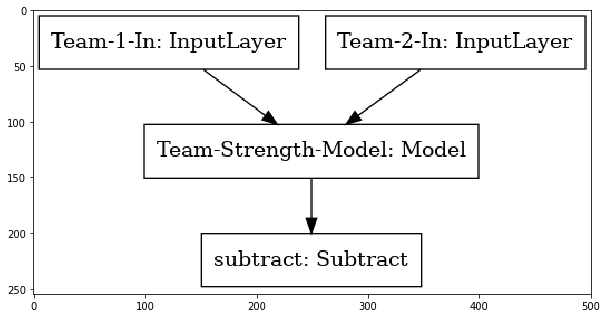

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='../images/embedding_shared_merge_model.png')

data = plt.imread('../images/embedding_shared_merge_model.png')
plt.imshow(data);

## Predict from your model

### Fit the model to the regular season training data
Now that you've defined a complete team strength model, you can fit it to the basketball data! Since your model has two inputs now, you need to pass the input data as a list.



In [10]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2], games_season['score_diff'], epochs=1, batch_size=2048, validation_split=0.1, verbose=True);

138/138 [==============================] - 0s 2ms/step - loss: 12.1205 - val_loss: 11.8391


### Evaluate the model on the tournament test data
In this exercise, you will evaluate the model on this new dataset. This evaluation will tell you how well you can predict the tournament games, based on a model trained with the regular season data. This is interesting because many teams play each other in the tournament that did not play in the regular season, so this is a very good check that your model is not overfitting.

In [11]:
games_tourney = pd.read_csv('./dataset/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [12]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], games_tourney['score_diff'], verbose=False))

11.682927131652832
